In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from scipy.signal import fftconvolve
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

In [2]:
hbar = 1.05 * 10**(-34)
e = 1.6 * 10**(-19)
Phi0 = np.pi * hbar / e

# Objects

## Transmon

<img src="img/transmon.png" align="right" alt="Drawing" style="width: 400px;"/>

$E_{j1} = \cfrac{\hbar I_{j1}}{2e}$

$E_{j2} = \cfrac{\hbar I_{j2}}{2e}$ (если есть)

$\Phi_{ext} = MI$

$E_j = \sqrt{E_{j1}^2 + E_{j2}^2 + 2E_{j1}E_{j2}\cos(2e \Phi_{ext}/\hbar)}$

$E_c = \cfrac{e^2}{2(C + C_r + C_l + C_u)} = \cfrac{e^2}{2(C + C_{neighbours})}$

$\hbar \omega = \sqrt{(8 E_c E_j)}$

$E_{n, n+1} = \sqrt{(8 E_c E_j)} - E_c(n+1)$

In [3]:
class Transmon:
# properties
    # n - number of levels
    # psi - wave function
    # C capacity
    # Ej
    # Ec
    # w - array of freq 0-1, 1-2 ...
    # psi - wave function (defaulf [1, 0 , 0 ...])
    # gamma
    # Cnb
    # M
    # I
    # Ej1, Ej2
    
    def __init__(self, psi, C, Ij1, Ij2 = 0, M = 0, I = 0, Cnb = [0], gamma = 0):
        
        # number of levels
        self.n = len(psi)
        
        #C, Ij1, Ij2, M, I, Cnb, Ej, Ec, w, Ej1, Ej2
        self.C = C
        self.Ij1 = Ij1
        self.Ij2 = Ij2
        self.M = M
        self.I = I
        self.Cnb = Cnb
        self.gamma = gamma
        
        Ej1 = hbar * Ij1 / (2 * e)
        Ej2 = hbar * Ij2 / (2 * e)
        self.Ej1, self.Ej2 = Ej1, Ej2
        Phiext = I * M
        self.Ej = np.sqrt(Ej1**2 + Ej2**2 + 2 * Ej1 * Ej2 * np.cos(2 * e / hbar * Phiext))
        self.Ec = e**2 / 2 / (C + np.sum(Cnb))
        self.w = np.zeros(self.n - 1)
        for i in range(1, self.n):
            self.w[i-1] = np.sqrt(8 * self.Ec * self.Ej) / hbar - self.Ec * i / hbar
            self.w[i-1] *= 10**(-9)

        
        #wave fucntion
        self.psi = np.array(psi, dtype = complex)
        if self.psi.size != self.n:
            print('error, wrong size of transmon.psi')
        self.psi = self.psi / np.linalg.norm(self.psi)
        self.psi.shape = (self.n, 1)

## Ocsillator

$\hbar \omega = \cfrac{\hbar}{\sqrt{L (C + C_{nb})}}$

$E_{n-1, n} = \hbar \omega$

In [4]:
class Oscillator:
# properties
    # n - number of levels
    # C - capacity
    # psi - wave function
    # w - array of freq 0-1, 1-2 ...
    # psi - wave function (defaulf [1, 0 , 0 ...])
    # gamma
    
    def __init__(self, psi, C, L, Cnb = [0], gamma = 0, noise = 1):
        
        # number of levels
        self.n = len(psi)
        
        #gamma, noise, L, С, w
        self.gamma = gamma
        self.noise = noise
        self.L = L
        self.C = C
        self.w = np.array([1/np.sqrt(L * (C + np.sum(Cnb)))] * (self.n - 1)) * 10**(-9)
        
        #wave fucntion
        self.psi = np.array(psi, dtype = complex)
        if self.psi.size != self.n:
            print('error, wrong size of oscillator.psi')
        self.psi = self.psi / np.linalg.norm(self.psi)
        self.psi.shape = (self.n, 1)

## Coupling

$G = \cfrac{C \sqrt{\omega_1\omega_2}}{2\sqrt{(C+C_1)(C+C_2)}}$

In [5]:
class Coupling():
    
    def __init__(self, C):
        self.C = C
        self.G = C / 2

## InSignal

накачка вида $\Omega(t) (a^\dagger + a)$

In [6]:
class InSignal():

# drive
# cur
# change_freq 0 если обычная накачка, 1 если меняем частоту кубита
# qmixer - quadrature_mixer
    
    def __init__(self, change_freq = 0):
        self.dt = 1.
        # Carrier signal
        self.carrier_frequency = 5.
        self.power = 1.
        # Modulation signal
        self.waveform = np.array([[], []], dtype = complex)
        self.nop = 0 #длина waveform
        self.clock = 1 #в наносекундах
        # Input signal
        self.drive = np.array([])
        self.cur = 0
        self.change_freq = change_freq
        
    def upd_insignal(self):
        # checking
        if self.nop != self.waveform[0].size or self.nop != self.waveform[1].size:
            print('(!) self.nop != self.waveform[0].size == self.waveform[1].size')
        if self.nop * self.waveform[0].size * self.waveform[1].size == 0:
            return
        # generating signal
        t = np.arange(0, self.nop*self.clock, self.dt) 
            # streching signal
        waveform_scretched = np.zeros((2, t.size))
        plt.plot(t, stretch_array(self.waveform[0], t.size))
        plt.plot(t, SignalProcessingWithCheby1(stretch_array(self.waveform[0], t.size), t))
        plt.show()
        waveform_scretched[0] = SignalProcessingWithCheby1(stretch_array(self.waveform[0], t.size), t, cutoff_freq = 1)
        waveform_scretched[1] = SignalProcessingWithCheby1(stretch_array(self.waveform[1], t.size), t, cutoff_freq = 1)
        VL = np.zeros((2, t.size))
        VL[0] = self.power * np.sin(2 * np.pi * self.carrier_frequency * t)
        VL[1] = self.power * np.cos(2 * np.pi * self.carrier_frequency * t)
        self.drive = VL[0] * waveform_scretched[0] + VL[1] * waveform_scretched[1]
        self.cur = self.drive.size

## Filters

### Cheby1

In [7]:
# по массиву частот и параметров возвращает фильрующий массив
def Cheby1Filter(freq, n, rs, cutoff_freq):
    # частоты, порядок фильтра, minimum attenuation in -dB, cutoff frequency
    eps = np.sqrt(10**(0.1*rs) - 1) #расчитываем eps из minimum attenuation in -dB
    c = np.append(np.zeros(n), eps)
    freq = np.asarray(freq, dtype = complex)
    cheby2_filter = 1/np.sqrt(1 + (np.polynomial.chebyshev.chebval(freq/cutoff_freq, c)**2))
    return(cheby2_filter)

#обрабатывает сигнал через cheby1
def SignalProcessingWithCheby1(signal, time, n = 2, rs = 0.3, cutoff_freq = 1):
    fsignal = np.fft.rfft(np.real(signal)) # F[signal]
    freq = np.fft.rfftfreq(time.size, time[1] - time[0]) # преход в частотную область
    fsignal_processed = fsignal * Cheby1Filter(freq, n, rs, cutoff_freq)
    signal_processed = np.fft.irfft(fsignal_processed)
    return(signal_processed)

#пока не работает (!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!)
def SignalProcessingWithCheby1_withoutFsignal(signal, time, n = 2, rs = 0.3, cutoff_freq = 1):
    freq = np.fft.rfftfreq(time.size, time[1] - time[0]) # преход в частотную область
    fcheby1 = np.fft.irfft(Cheby1Filter(freq, n, rs, cutoff_freq))
    signal_processed = fftconvolve(signal, fcheby1, 'same')
    return(signal_processed)


def test_SignalProcessingWithCheby1():
    freq = np.arange(0, 10, 0.001)
    k = Cheby1Filter(freq, 2, 0.3, 1)
    plt.plot(freq, k)
    plt.show()

    t = np.arange(0, 1, 0.01)
    x = np.sin(2 * np.pi* 0.3 * t)
    plt.plot(t, x)
    plt.plot(t, SignalProcessingWithCheby1(x, t, cutoff_freq = 1))

    plt.show()

### Cheby2

In [8]:
def Cheby2Filter(freq, n, rs, cutoff_freq):
    # частоты, порядок фильтра, minimum attenuation in -dB, cutoff frequency
    eps = 1/np.sqrt(10**(0.1*rs) - 1) #расчитываем eps из minimum attenuation in -dB
    c = np.append(np.zeros(n), eps)
    freq = np.asarray(freq, dtype = complex)
    cheby2_filter = 1/np.sqrt(1 + 1/(np.polynomial.chebyshev.chebval(freq**(-1)*cutoff_freq, c)**2))
    return(cheby2_filter)


def SignalProcessingWithCheby2(signal, time, n = 4, rs = 30, cutoff_freq = 2*np.pi):
    fsignal = np.fft.rfft(np.real(signal)) # F[signal]
    freq = np.fft.rfftfreq(time.size, time[1] - time[0]) # преход в частотную область
    fsignal_processed = fsignal * Cheby2Filter(freq, n, rs, cutoff_freq)
    signal_processed = np.fft.irfft(fsignal_processed)
    return(signal_processed)

## Circuit

In [9]:
# Для записи цепей. Цепь записывается через массив элементов цепи (вершины) и список ребер.
class Circuit():
    
# dt
# elements
# adjlist
# psi
# psiwrite
# a 
# ad
# H
# Hwrite
# HwriteRWB
    
    def __init__(self, elements, adjlist, dt):
        self.dt = dt
        self.elements = np.asarray(elements)
        self.adjlist = np.asarray(adjlist)
        self.psi, self.psiwrite = CreatePsi(self)
        
        # передаем dt в Insignal
        for i in range (0, self.elements.size):
            if self.elements[i].__class__.__name__ == 'InSignal':
                self.elements[i].dt = dt
        
        # находим константы связи G
        for i in range(0, self.elements.size):
            if self.elements[i].__class__.__name__ == 'Coupling':
                self.elements[i].G = self.elements[i].C / 2
                tmp = self.adjlist[i][0]
                self.elements[i].G *= np.sqrt(self.elements[tmp].w[0]/(self.elements[i].C + self.elements[tmp].C))
                tmp = self.adjlist[i][1]
                self.elements[i].G *= np.sqrt(self.elements[tmp].w[0]/(self.elements[i].C + self.elements[tmp].C))
                
            if self.elements[i].__class__.__name__ == 'Transmon': #перерасчет частоты трансмона из-за сосдених емкостей
                Cnb = [0]
                for el in adjlist[i]:
                    if self.elements[el].__class__.__name__ == 'Coupling':
                        Cnb = np.append(Cnb, self.elements[el].C)
                self.elements[i] = Transmon(psi = self.elements[i].psi,\
                                            C = self.elements[i].C,\
                                            Ij1 = self.elements[i].Ij1,
                                            Ij2 = self.elements[i].Ij2,\
                                            M = self.elements[i].M,\
                                            I = self.elements[i].I,\
                                            Cnb = Cnb,\
                                            gamma = self.elements[i].gamma)
                
            if self.elements[i].__class__.__name__ == 'Oscillator': #перерасчет частоты резонатора из-за сосдених емкостей
                Cnb = [0]
                for el in adjlist[i]:
                    if self.elements[el].__class__.__name__ == 'Coupling':
                        Cnb = np.append(Cnb, self.elements[el].C)
                self.elements[i] = Oscillator(psi = self.elements[i].psi,\
                                              C = self.elements[i].C,\
                                              L = self.elements[i].L,\
                                              Cnb = Cnb,\
                                              gamma = self.elements[i].gamma,\
                                              noise = self.elements[i].noise)


        self.a, self.ad = CreateAAd(self)
        self.H = CreateHamiltonian(self)
        self.Hwrite, self.HwriteRWB = CreateHamiltonianWrite(self)
        self.rwb, self.rwbd = CreateRWB(self)
        
    def display_info(self):
        print(self.Hwrite)
        print(self.HwriteRWB)
        
    def upd_insignal(self, element_cur, drive): #индекс InSignal в circuit и массив сигналов
        #time = np.arange(0, drive.size) * self.dt
        #drive = SignalProcessingWithCheby1(drive, time, n = 2, rs = 0.3, cutoff_freq = 2*np.pi)
        if self.elements[element_cur].__class__.__name__ != 'InSignal':
            print('error, singnal is given not to InSignal vertice but to vertice ' + str(element_cur) + ' '\
                  +  self.elements[element_cur].__class__.__name__)
        else:
            self.elements[element_cur].drive = np.asarray(drive)
            self.elements[element_cur].cur = 0
            
    def gen_sin_sig(self, element_cur, t_long, ampl):
        #circuit, element_cur - current of the resonator in circuit
        #t_long - long of the impulse (dt is known form circuit.dt)
        #ampl - amplitude of oscillations
        if self.elements[element_cur].__class__.__name__ != 'InSignal':
            print("Try to applay dispersive_readout not to the InSignal")
            print(self.elements[element_cur].__class__.__name__)
        else:
            time = np.arange(0, t_long, self.dt)
            drive = ampl * np.sin(self.elements[self.adjlist[element_cur][0]].w[0] * time)
            self.upd_insignal(element_cur, drive)
            return(drive.size)

# Operators (fuctions)

## CreatePsi

In [10]:
# волновая функиция по circuit 
def CreatePsi(circuit):
    psi = np.array([], dtype = complex)
    psiwrite = chr(936) + ' = '
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__:
            if psi.size == 0:
                psi = circuit.elements[i].__dict__.get('psi')
                psiwrite = psiwrite + chr(936) + str(i)
            else:
                psi = np.kron(psi, circuit.elements[i].__dict__.get('psi'))
                psiwrite = psiwrite + chr(8855) + chr(936) + str(i)
    return(psi, psiwrite)

## CreateAAd

In [11]:
# операторы рождения и уничтожения по circuit
# RWB = 0. - не учитывается RWB
# RWB = 1. - учитывается (1 число шагов по времени)
def CreateAAd(circuit):
    n = circuit.psi.size
    a = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    ad = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    cnt = 1
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            if cnt == 1:
                tmpa = np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex), k = 1))
                tmpad = tmpa.transpose()
            else:
                tmpa = np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex), k = 1))
                tmpad = tmpa.transpose()
                tmpa = np.kron(np.identity(cnt), tmpa)
                tmpad = np.kron(np.identity(cnt), tmpad)
            cnt *=  circuit.elements[i].n
            if cnt < circuit.psi.size:
                tmpa = np.kron(tmpa, np.identity(circuit.psi.size // cnt))
                tmpad = np.kron(tmpad, np.identity(circuit.psi.size // cnt))
            a[i] = tmpa
            ad[i] = tmpad
    return(a, ad)

In [12]:
def CreateRWB(circuit):
    n = circuit.psi.size
    rwb = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    rwbd = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    cnt = 1
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            if cnt == 1:
                tmpa = np.diag(np.append(np.zeros(1), np.exp(- 1j * circuit.elements[i].w * circuit.dt)))
                tmpad = np.diag(np.append(np.exp(1j * circuit.elements[i].w * circuit.dt), np.zeros(1)))
            else:
                tmpa = np.diag(np.append(np.zeros(1), np.exp(- 1j * circuit.elements[i].w * circuit.dt)))
                tmpad = np.diag(np.append(np.exp(1j * circuit.elements[i].w * circuit.dt), np.zeros(1)))
                tmpa = np.kron(np.identity(cnt), tmpa)
                tmpad = np.kron(np.identity(cnt), tmpad)
            cnt *=  circuit.elements[i].n
            if cnt < circuit.psi.size:
                tmpa = np.kron(tmpa, np.identity(circuit.psi.size // cnt))
                tmpad = np.kron(tmpad, np.identity(circuit.psi.size // cnt))
            rwb[i] = tmpa
            rwbd[i] = tmpad
    return(rwb, rwbd)

## CreateHamiltonian

In [13]:
# по circuit выводит гамильтониан системы
def CreateHamiltonian(circuit):
    H = np.zeros((circuit.psi.size, circuit.psi.size), dtype = complex)
    for i in range(0, circuit.elements.size):
        # член взаимодействия
        if circuit.elements[i].__class__.__name__ == 'Coupling':
            tmp = circuit.adjlist[i][0]
            tmpH1 = circuit.ad[tmp] + circuit.a[tmp]
            tmp = circuit.adjlist[i][1]
            tmpH2 = circuit.ad[tmp] + circuit.a[tmp]
            H = H + circuit.elements[i].G * np.dot(tmpH1, tmpH2)
        
        # член затухания
        if circuit.elements[i].__class__.__name__ == 'Transmon' or\
           circuit.elements[i].__class__.__name__ == 'Oscillator':
            H = H - 1j * circuit.elements[i].gamma * np.dot(circuit.ad[i], circuit.a[i]) / 2.
        
        # шум
        if circuit.elements[i].__class__.__name__ == 'Oscillator':
            #  просто проверка на всякий случай
            if circuit.elements[i].gamma * circuit.elements[i].noise != 0:
                x = np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[i] + circuit.a[i]), circuit.psi))
                J = (np.real(x)/2* np.sqrt(circuit.elements[i].gamma) + random.gauss(0, 1)/np.sqrt(circuit.dt))
                H = H + 1j * np.sqrt(circuit.elements[i].gamma) * J * circuit.a[i]
                
        # накачка
        if circuit.elements[i].__class__.__name__ == 'InSignal':
            if circuit.elements[i].cur < circuit.elements[i].drive.size:
                tmp = circuit.adjlist[i][0]
                if circuit.elements[i].change_freq == 0: #добавляем накачку
                    H = H - circuit.elements[i].drive[circuit.elements[i].cur] * (circuit.a[tmp] + circuit.ad[tmp])
                elif circuit.elements[i].change_freq == 1: #меняем частоту кубита
                    if circuit.elements[tmp].__class__.__name__ == 'Transmon':
                        circuit.elements[tmp] = Transmon(psi = circuit.elements[tmp].psi,\
                                                         C = circuit.elements[tmp].C,\
                                                         Ij1 = circuit.elements[tmp].Ij1,
                                                         Ij2 = circuit.elements[tmp].Ij2,\
                                                         M = circuit.elements[tmp].M,\
                                                         I = circuit.elements[i].drive[circuit.elements[i].cur],\
                                                         Cnb = circuit.elements[tmp].Cnb,\
                                                         gamma = circuit.elements[tmp].gamma)
                        circuit.rwb, circuit.rwbd = CreateRWB(circuit)
                    else:
                        print('You are changing frequency of the wrong element (' \
                              + circuit.elements[i].__class__.__name__ +')')
                circuit.elements[i].cur += 1
                    
    return (H)

In [14]:
def CreateHamiltonianWrite(circuit):
    Hwrite = 'H = '
    HwriteRWB = 'H_RWB = '
    for i in range(0, circuit.elements.size):
        if circuit.elements[i].__class__.__name__ == 'Transmon' or\
           circuit.elements[i].__class__.__name__ == 'Oscillator':
            Hwrite = Hwrite + ' + \u0127\u03C9_' + str(i) + 'a' + chr(8314) + '_' + str(i) + 'a_' + str(i)
        if circuit.elements[i].__class__.__name__ == 'Coupling':
            Hwrite = Hwrite + ' + \u0127g_' + str(i)
            HwriteRWB = HwriteRWB + ' + \u0127g_' + str(i)
            tmp = circuit.adjlist[i][0]
            Hwrite = Hwrite + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
            HwriteRWB = HwriteRWB + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
            tmp = circuit.adjlist[i][1]
            Hwrite = Hwrite + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
            HwriteRWB = HwriteRWB + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
    return (Hwrite, HwriteRWB)

## RK4

In [15]:
# evolution for RK4
def FuncEvolution(psi, circuit):
    dpsi = - 1j * np.dot(circuit.H, psi)
    return(dpsi)

def RK4(circuit):
    k1 = FuncEvolution(circuit.psi, circuit)
    k2 = FuncEvolution(circuit.psi + circuit.dt/2 * k1, circuit)
    k3 = FuncEvolution(circuit.psi + circuit.dt/2 * k2, circuit)
    k4 = FuncEvolution(circuit.psi + circuit.dt * k3, circuit)
    circuit.psi = (circuit.psi + circuit.dt/6 * (k1 + 2*k2 + 2*k3 + k4))
    circuit.psi = circuit.psi / np.linalg.norm(circuit.psi)
    
    #recount annihilation and creation operatored due to RWB
    #circuit.a, circuit.ad = CreateAAd(circuit, RWB_time)
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            circuit.a[i] = np.dot(circuit.a[i], circuit.rwb[i])
            circuit.ad[i] = np.dot(circuit.ad[i], circuit.rwbd[i])
    
    
    #recount Hamiltonian
    circuit.H = CreateHamiltonian(circuit)
            
    return(circuit)

## Find_freq

In [16]:
# по сигналу находит его частоту
def Find_freq(x, dt, plot = False):
    fx = np.fft.rfft(np.real(x)) # F[signal]
    freq = np.fft.rfftfreq(x.size, dt) # преход в частотную область
    if plot:
        plt.plot(freq, np.abs(fx))
        plt.show()
    return(freq[np.argmax(np.abs(fx))])

## func_for_disp_readout

In [17]:
def func_for_disp_readout(t, gamma, a, phi, f):
    return(a * np.sin(2*np.pi*f*t + phi) * np.exp(- gamma * t))

## stretch_array

In [18]:
def stretch_array(originalArray, targetSize):
    x = np.linspace(0, originalArray.size, num=targetSize)
    if targetSize >= originalArray.size:
        x = -np.flip(x, axis=0) + originalArray.size
        x[-1] = originalArray.size - 1
    if targetSize < originalArray.size:
        print('you want to squeeze array')
    x = originalArray[x.astype(int)]
    return x
#np.repeat

## Quadrature mixer func

<img src="img/КвадрСмес.png" align="left" alt="Drawing" style="width: 500px;"/>

In [19]:
def Quadrature_mixer_func():
    A = 1
    I0 = 0.3
    Q0 = -0.3
    fc = 10
    fI = fQ = 2
    L = 1

    t = np.arange(0, 1, 0.01)
    VL = A * np.sin(2 * np.pi * fc * t)
    VLL = A * np.cos(2 * np.pi * fc * t)
    I = I0 * np.sin(2 * np.pi * fI * t)
    Q = Q0 * np.cos(2 * np.pi * fQ * t)
    VR = VL * I * L + VLL * Q * L

    #checking
    VR_check = 0.5 * A * (I0 + Q0) * np.cos(2 * np.pi * (fc - fI) * t) -\
               0.5 * A * (I0 - Q0) * np.cos(2 * np.pi * (fc + fI) * t)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    ax1.plot(t, VL + VLL)
    ax1.set_title("Carrier signal")
    ax2.plot(t, I + Q)
    ax2.set_title("Modulation signal")
    ax3.plot(t, VR)
    ax3.plot(t, VR_check)
    ax3.set_title("Output signal")
    ax3.set_xlabel("time")
    fig.tight_layout()
    plt.show()

# Devices

## LO

In [20]:
class LO():
    def __init__(self, insignal):
        self.insignal = insignal
    
    def set_frequency(self, frequency):
        self.insignal.carrier_frequency = frequency
    
    def set_power(self, power):
        self.insignal.power = power

## AWG

In [21]:
class AWG():
    def __init__(self, insignal):
        self.insignal = insignal
    
    def set_waveform(self, waveform, channel): #channel = 0, 1
        if self.insignal.waveform[channel].size == waveform.size:
            self.insignal.waveform[channel] = np.asarray(waveform)
        else:
            print('insignal.nop != waveform.size')
    
    def set_nop(self, nop):
        self.insignal.nop = nop
        self.insignal.waveform = np.reshape(np.zeros(2 * nop), (2, nop))
    
    def set_clock(self, clock):
        self.insignal.clock = clock

## Measuring Instrument

In [22]:
class MI():
    
    def __init__(self):
        self.circuit = None
        self.nums = 1
        self.nop = 0
    
    
    def set_circuit(self, circuit):
        self.circuit = circuit
    
    
    def set_nums(self, nums):
        self.nums = nums
    
    
    
    def set_nop(self, nop):
        self.nop = nop
        
        
        
        
    def measure_everything_initial(self, measure_elements = None, cov_signals = np.array([])):
        # fill measure elements
        if measure_elements == None:
            measure_elements = np.array([], dtype = int)
            for i in range (self.circuit.elements.size):
                if self.circuit.elements[i].__class__.__name__ == 'Oscillator' or\
                   self.circuit.elements[i].__class__.__name__ == 'Transmon':
                    measure_elements = np.append(measure_elements, i)
        measure_elements = np.asarray(measure_elements)
        #create result measure
        measure = {'x'+ str(el): np.zeros((self.nop), dtype = complex) for el in measure_elements}
        measure.update({'z'+ str(el): np.zeros((self.nop), dtype = complex) for el in measure_elements})
        measuretmp = measure.copy()
        #cov
        for j in range(len(cov_signals)):
            for key1 in measuretmp.keys():
                measure.update({key1 + '@sig' + str(j): np.zeros((self.nums), dtype = complex)})
        
        for num in range(0, self.nums):
            circuit = copy.copy(self.circuit)
            # upd insignals
            for i in range (0, self.circuit.elements.size):
                if self.circuit.elements[i].__class__.__name__ == 'InSignal':
                    self.circuit.elements[i].upd_insignal()
            
            #evolution
            for el in measure_elements:
                measuretmp['x' + str(el)][0] = np.dot(np.conj(circuit.psi.transpose()),\
                                                   np.dot(circuit.ad[el] + circuit.a[el], circuit.psi))
                measuretmp['z' + str(el)][0] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[el],\
                                                    np.dot(circuit.a[el], circuit.psi)))
            for i in range(1, self.nop):
                circuit = RK4(circuit)
                for el in measure_elements:
                    measuretmp['x' + str(el)][i] = np.dot(np.conj(circuit.psi.transpose()),\
                                                     np.dot(circuit.ad[el] + circuit.a[el], circuit.psi))
                    measuretmp['z' + str(el)][i] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[el],\
                                                        np.dot(circuit.a[el], circuit.psi)))
            #cov
            for j in range(len(cov_signals)):
                for key1 in measuretmp.keys():
                    measure[key1 + '@sig' + str(j)][num] = np.sum(measuretmp[key1] * cov_signals[j])

            for key in measuretmp.keys():
                measure[key] += measuretmp[key]
                
        return measure

    
    
    def measure_everything(self, freq, power, cutoff_freq, clock, measure_elements=None, cov_signals = np.array([])):
        # fill measure elements
        if measure_elements == None:
            measure_elements = np.array([], dtype = int)
            for i in range (self.circuit.elements.size):
                if self.circuit.elements[i].__class__.__name__ == 'Oscillator' or\
                   self.circuit.elements[i].__class__.__name__ == 'Transmon':
                    measure_elements = np.append(measure_elements, i)
        measure_elements = np.asarray(measure_elements)
        #create result measure
        measure = {'x'+ str(el): np.zeros((round(self.nop / clock * self.circuit.dt)), dtype = complex) for el in measure_elements}
        measure.update({'z'+ str(el): np.zeros((round(self.nop / clock * self.circuit.dt)), dtype = complex) for el in measure_elements})
        #cov
        for j in range(len(cov_signals)):
            for key1 in measure.keys():
                measure.update({key1 + '@sig' + str(j): np.zeros((self.nums), dtype = complex)})
        
        for num in range(0, self.nums):
            circuit = copy.copy(self.circuit)
            # upd insignals
            for i in range (0, self.circuit.elements.size):
                if self.circuit.elements[i].__class__.__name__ == 'InSignal':
                    self.circuit.elements[i].upd_insignal()
            
            measuretmp = {'x'+ str(el): np.zeros((self.nop), dtype = complex) for el in measure_elements}
            measuretmp.update({'z'+ str(el): np.zeros((self.nop), dtype = complex) for el in measure_elements})
            #evolution
            for el in measure_elements:
                measuretmp['x' + str(el)][0] = np.dot(np.conj(circuit.psi.transpose()),\
                                                   np.dot(circuit.ad[el] + circuit.a[el], circuit.psi))[0,0]
                measuretmp['z' + str(el)][0] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[el],\
                                                    np.dot(circuit.a[el], circuit.psi)))[0,0]
            for i in range(1, self.nop):
                circuit = RK4(circuit)
                for el in measure_elements:
                    measuretmp['x' + str(el)][i] = np.dot(np.conj(circuit.psi.transpose()),\
                                                     np.dot(circuit.ad[el] + circuit.a[el], circuit.psi))[0,0]
                    measuretmp['z' + str(el)][i] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[el],\
                                                        np.dot(circuit.a[el], circuit.psi)))[0,0]
            #cov
            time = np.sin(2 * np.pi * freq * np.arange(0, self.nop) * self.circuit.dt)
            #time = np.cos(2 * np.pi * freq * np.arange(0, self.nop) * self.circuit.dt)
            for key1 in measuretmp.keys():
                measuretmp[key1] = SignalProcessingWithCheby1(measuretmp[key1], time, cutoff_freq = cutoff_freq)
                #measuretmp[key1] += SignalProcessingWithCheby1(measuretmp[key1], time2, cutoff_freq = cutoff_freq)
                measuretmp[key1] = measuretmp[key1][::round(clock/self.circuit.dt)]
                for j in range(len(cov_signals)):
                    measure[key1 + '@sig' + str(j)][num] = np.sum(measuretmp[key1] * cov_signals[j])

                    
            for key in measuretmp.keys():
                measure[key][:measuretmp[key].size] += measuretmp[key]
                
        return measure



    
    def measure_insignal(self):
        cnt = 0 #число insignal
        cur_insignal = np.array([], dtype = int)
        max_drive_nop = 0 # длина самого длинного drive
        for i in range (0, self.circuit.elements.size):
            if self.circuit.elements[i].__class__.__name__ == 'InSignal':
                self.circuit.elements[i].upd_insignal()
                cnt += 1
                cur_insignal = np.append(cur_insignal, i)
                max_drive_nop = max(max_drive_nop, self.circuit.elements[i].drive.size)
                
        if cnt == 0:
            print('(!) no InSignals are found')
        else:
            output = np.reshape(np.zeros(cnt * max_drive_nop), (cnt, max_drive_nop))
            for i in range(0, cnt):
                output[i][:self.circuit.elements[cur_insignal[i]].drive.size] =\
                    self.circuit.elements[cur_insignal[i]].drive
                
        return cur_insignal, output

# exp

## input

### sim input

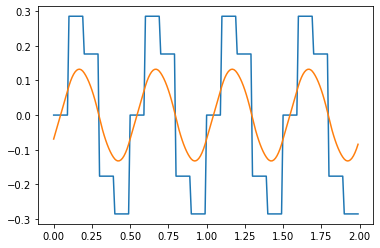

[0] (1, 200)


In [23]:
# цепь
dt = 0.01
t_end = 2
clock = 0.1
insignal = InSignal()
circuit = Circuit([insignal], [[]], dt = dt)
# приборы
lo = LO(insignal)
awg = AWG(insignal)
mi = MI()
mi.set_circuit(circuit)

# paraments
A = 1
I0 = 0.3
Q0 = -0.3
fc = 10
fI = fQ = 2

# подача сигналов
lo.set_frequency(fc)
lo.set_power(1.)

t_clock = np.arange(0, t_end, clock)
awg.set_nop(t_clock.size)
awg.set_waveform(I0 * np.sin(2 * np.pi * fI * t_clock), 0)
awg.set_waveform(Q0 * np.cos(2 * np.pi * fQ * t_clock), 1)
awg.set_clock(clock)

t = np.arange(0, t_end, dt)
# считываение сигналов
cur_insignal, output = mi.measure_insignal()
print(cur_insignal, output.shape)

### check input

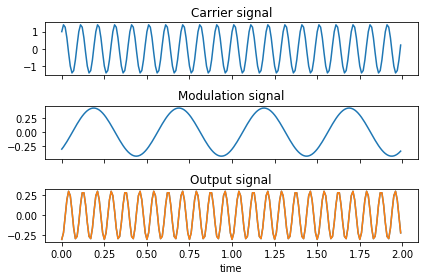

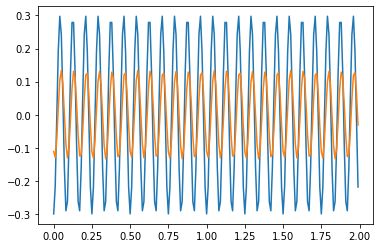

In [24]:
#A = 1
#I0 = 0.3ß
#Q0 = -0.3
#fc = 10
#fI = fQ = 2
L = 1

VL = A * np.sin(2 * np.pi * fc * t)
VLL = A * np.cos(2 * np.pi * fc * t)
I = I0 * np.sin(2 * np.pi * fI * t)
Q = Q0 * np.cos(2 * np.pi * fQ * t)
VR = VL * I * L + VLL * Q * L

#checking
VR_check = 0.5 * A * (I0 + Q0) * np.cos(2 * np.pi * (fc - fI) * t) -\
           0.5 * A * (I0 - Q0) * np.cos(2 * np.pi * (fc + fI) * t)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(t, VL + VLL)
ax1.set_title("Carrier signal")
ax2.plot(t, I + Q)
ax2.set_title("Modulation signal")
ax3.plot(t, VR)
ax3.plot(t, VR_check)
ax3.set_title("Output signal")
ax3.set_xlabel("time")
fig.tight_layout()
plt.show()

plt.plot(t, VR)
plt.plot(t, output[cur_insignal[0]])
plt.show()

## disp_readout output

In [43]:
C = 5*10**(-14)
Ij = 40*e**3/hbar/C
L = 2 * 10**(-8)
M = 2 * 10**(-8)
#I = 1.72 * 10**(-8)
Time = 200
dt = 0.01
nums = 2

transmon = Transmon(psi = [1, 0], C = C, Ij1 = Ij, Ij2 = 0, M = 0)
coupling = Coupling(C /60)
alpha = 1
n_osc = 6
gamma = 0.01
osc = Oscillator(psi= np.exp(-alpha**2/2)*alpha**np.arange(n_osc)/np.sqrt(scipy.special.factorial(np.arange(n_osc))),\
                 L = L, C = C/1., gamma = gamma, noise = 1)
drive_osc = InSignal()
circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)


mi = MI()
mi.set_circuit(circuit)
mi.set_nums(nums)
mi.set_nop(round(Time//dt + 1))
signal0 = mi.measure_everything_initial()

transmon = Transmon(psi = [0, 1], C = C, Ij1 = Ij, Ij2 = 0, M = 0)
circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)
mi.set_circuit(circuit)
signal1 = mi.measure_everything_initial()

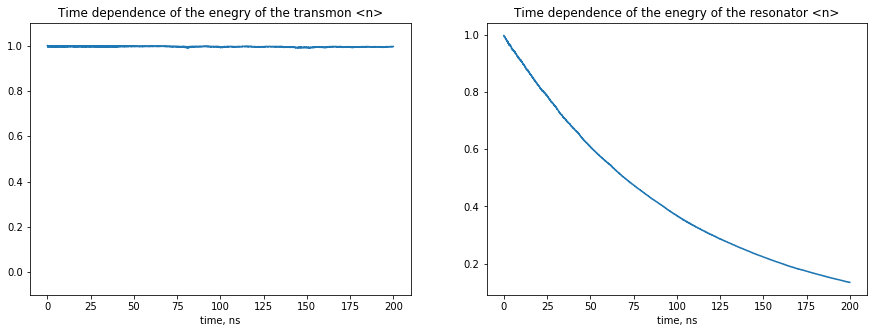

In [44]:
time = np.linspace(0, Time, Time // dt + 1)
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(signal1['z0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>")
f1.set_xlabel('time, ns')
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(signal0['z2'])/nums)
f2.set_title("Time dependence of the enegry of the resonator <n>")
f2.set_xlabel('time, ns')
plt.show()

In [45]:
transmon = Transmon(psi = [1, 0], C = C, Ij1 = Ij, Ij2 = 0, M = 0)
circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)
nums = 3
mi.set_nums(nums)
mi.set_circuit(circuit)
print(signal0.keys())
print(signal1.keys())
measure = mi.measure_everything_initial(cov_signals = np.array([signal0['x0'], signal1['x0']]))

dict_keys(['x0', 'x2', 'z0', 'z2'])
dict_keys(['x0', 'x2', 'z0', 'z2'])


In [46]:
measure.keys()

dict_keys(['x0', 'x2', 'z0', 'z2', 'x0@sig0', 'x2@sig0', 'z0@sig0', 'z2@sig0', 'x0@sig1', 'x2@sig1', 'z0@sig1', 'z2@sig1'])

In [47]:
measure

{'x0': array([ 0.        +0.00000000e+00j,  0.00517201+0.00000000e+00j,
         0.00455878-1.08420217e-19j, ..., -0.01897867+2.16840434e-18j,
        -0.04681263+7.80625564e-18j, -0.06402313-1.73472348e-18j]),
 'x2': array([-3.98766409+2.16840434e-19j, -3.80025864-1.38796936e-17j,
        -3.24197169+1.77809156e-17j, ..., -0.64611093-2.77555756e-17j,
        -1.00719895-2.77555756e-17j, -1.27048505+0.00000000e+00j]),
 'z0': array([0.00000000e+00+0.00000000e+00j, 8.55382693e-05+3.53735696e-22j,
        3.53311391e-06-2.11758237e-22j, ...,
        1.65896122e-03+5.42101086e-20j, 1.84328558e-03-5.42101086e-20j,
        1.95091262e-03-1.08420217e-19j]),
 'z2': array([1.99386503-9.44878484e-19j, 1.99398947+3.38698185e-17j,
        1.99387929-2.81892565e-17j, ..., 0.2564211 -1.38777878e-17j,
        0.25660649+0.00000000e+00j, 0.25667086-2.77555756e-17j]),
 'x0@sig0': array([ 27.51605781-6.62748182e-17j,  60.90595355-2.76318703e-17j,
        -23.16138332-4.32365282e-17j]),
 'x2@sig0': array

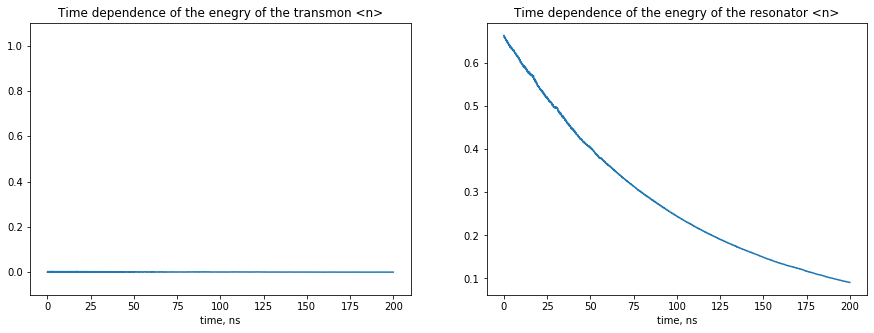

In [29]:
time = np.linspace(0, Time, Time // dt + 1)
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(measure['z0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>")
f1.set_xlabel('time, ns')
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(measure['z2'])/nums)
f2.set_title("Time dependence of the enegry of the resonator <n>")
f2.set_xlabel('time, ns')
plt.show()

## disp read

In [30]:
C = 5*10**(-14)
Ij = 40*e**3/hbar/C
L = 2 * 10**(-8)
M = 2 * 10**(-8)
#I = 1.72 * 10**(-8)
Time = 200
dt = 0.01
nums = 2

transmon = Transmon(psi = [1, 0], C = C, Ij1 = Ij, Ij2 = 0, M = 0)
coupling = Coupling(C /60)
alpha = 1
n_osc = 6
gamma = 0.01
osc = Oscillator(psi= np.exp(-alpha**2/2)*alpha**np.arange(n_osc)/np.sqrt(scipy.special.factorial(np.arange(n_osc))),\
                 L = L, C = C/1., gamma = gamma, noise = 1)
drive_osc = InSignal()
circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)


mi = MI()
mi.set_circuit(circuit)
mi.set_nums(nums)
mi.set_nop(round(Time//dt + 1))
#signal = mi.measure_everything(freq = 5, power = 1, cutoff_freq = 5, clock = 1.)
signal = mi.measure_everything(freq = 5, power = 1, cutoff_freq = 5, clock = 1.)

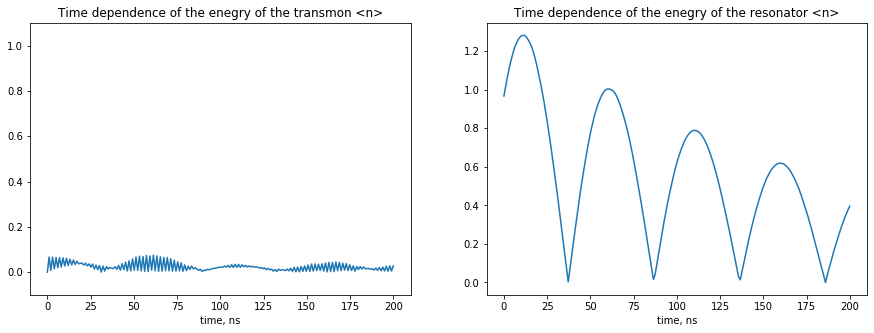

In [31]:
time = np.linspace(0, Time, Time // (clock*10) )
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(signal['x0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>")
f1.set_xlabel('time, ns')
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(signal['x2'])/nums)
f2.set_title("Time dependence of the enegry of the resonator <n>")
f2.set_xlabel('time, ns')
plt.show()

In [32]:
signal = mi.measure_everything_initial()

## for pict 2lvl

In [33]:
C = 5*10**(-14)
Ij = 40*e**3/hbar/C
L = 2 * 10**(-8)
M = 2 * 10**(-8)
#I = 1.72 * 10**(-8)
Time = 200
dt = 0.01
nums = 2

transmon = Transmon(psi = [1, 0], C = C, Ij1 = Ij, Ij2 = 0, M = 0)
coupling = Coupling(C /60)
alpha = 1
n_osc = 6
gamma = 0.01
osc = Oscillator(psi= np.exp(-alpha**2/2)*alpha**np.arange(n_osc)/np.sqrt(scipy.special.factorial(np.arange(n_osc))),\
                 L = L, C = C/1., gamma = gamma, noise = 1)
drive_osc = InSignal()
circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)


mi = MI()
mi.set_circuit(circuit)
mi.set_nums(nums)
mi.set_nop(round(Time//dt + 1))
signal0 = mi.measure_everything(freq = 5, power = 1, cutoff_freq = 5, clock = 1.)

In [34]:


transmon = Transmon(psi = [0, 1], C = C, Ij1 = Ij, Ij2 = 0, M = 0)
coupling = Coupling(C /60)
alpha = 1
n_osc = 6
gamma = 0.01
osc = Oscillator(psi= np.exp(-alpha**2/2)*alpha**np.arange(n_osc)/np.sqrt(scipy.special.factorial(np.arange(n_osc))),\
                 L = L, C = C/1., gamma = gamma, noise = 1)
drive_osc = InSignal()
circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)


mi = MI()
mi.set_circuit(circuit)
mi.set_nums(nums)
mi.set_nop(round(Time//dt + 1))
signal1 = mi.measure_everything(freq = 5, power = 1, cutoff_freq = 5, clock = 1.)

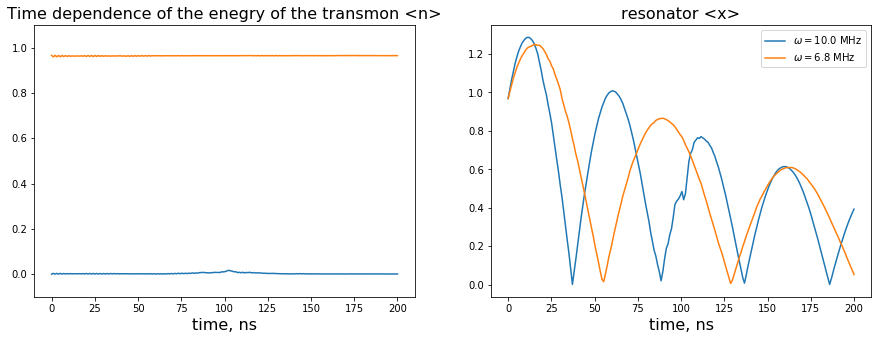

In [35]:
time = np.linspace(0, Time, Time // (clock*10) )
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(signal0['z0'])/nums)
f1.plot(time, np.abs(signal1['z0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>", size =16)
f1.set_xlabel('time, ns', size =16)
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(signal0['x2'])/nums, label='$\omega = 10.0$ MHz')
f2.plot(time, np.abs(signal1['x2'])/nums, label='$\omega = 6.8$ MHz')
f2.set_title("resonator <x>", size =16)
f2.set_xlabel('time, ns', size =16)
f2.legend()
plt.show()

[0.00513615 1.36133248 3.91434672 0.01006115]


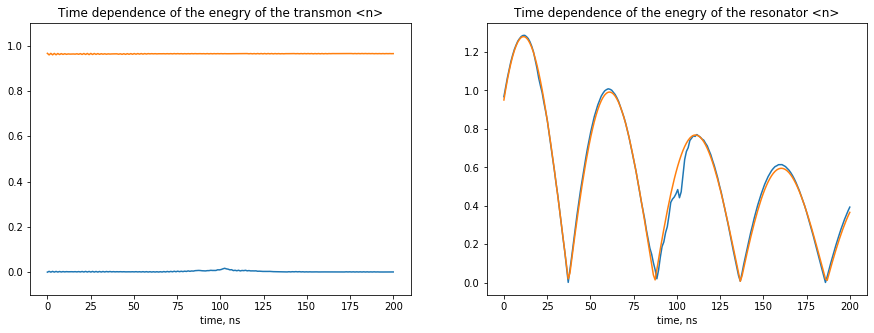

In [36]:
def func_for_disp(t, gamma, a, phi, f):
    return(np.abs(a * np.sin(2*np.pi*f*t + phi) * np.exp(- gamma * t)))
popt, pcov = curve_fit(func_for_disp, time, np.abs(signal0['x2'])/nums,\
                      bounds = ([0.009/2, 1, 0, 1/130], [0.011/2, 2, 2*np.pi, 1/70]))
print(popt)
time = np.linspace(0, Time, Time // (clock*10) )
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(signal0['z0'])/nums)
f1.plot(time, np.abs(signal1['z0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>")
f1.set_xlabel('time, ns')
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(signal0['x2'])/nums)
f2.plot(time, func_for_disp(time, *popt))
f2.set_title("Time dependence of the enegry of the resonator <n>")
f2.set_xlabel('time, ns')
plt.show()

[0.00490746 1.35098302 3.94948786 0.00677296]


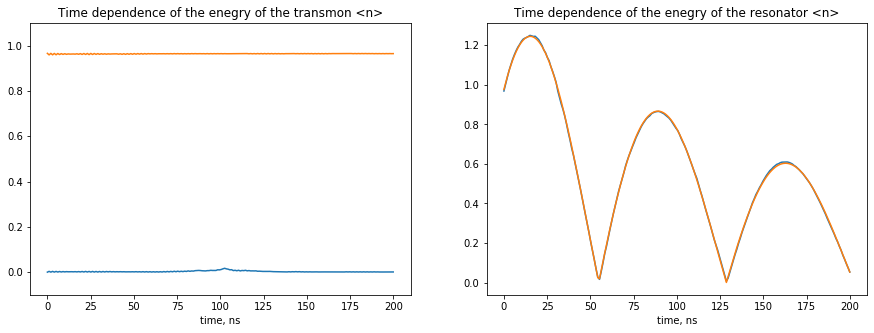

In [37]:
def func_for_disp(t, gamma, a, phi, f):
    return(np.abs(a * np.sin(2*np.pi*f*t + phi) * np.exp(- gamma * t)))
popt, pcov = curve_fit(func_for_disp, time, np.abs(signal1['x2'])/nums,\
                      bounds = ([0.009/2, 1, 0, 1/160], [0.011/2, 2, 2*np.pi, 1/70]))
print(popt)
time = np.linspace(0, Time, Time // (clock*10) )
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(signal0['z0'])/nums)
f1.plot(time, np.abs(signal1['z0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>")
f1.set_xlabel('time, ns')
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(signal1['x2'])/nums)
f2.plot(time, func_for_disp(time, *popt))
f2.set_title("Time dependence of the enegry of the resonator <n>")
f2.set_xlabel('time, ns')
plt.show()

## for pict 3lvl

In [38]:
C = 5*10**(-14)
Ij = 40*e**3/hbar/C
L = 2 * 10**(-8)
M = 2 * 10**(-8)
#I = 1.72 * 10**(-8)
Time = 200
dt = 0.01
nums = 2

transmon = Transmon(psi = [1, 0, 0], C = C, Ij1 = Ij, Ij2 = 0, M = 0)
coupling = Coupling(C /60)
alpha = 1
n_osc = 6
gamma = 0.01
osc = Oscillator(psi= np.exp(-alpha**2/2)*alpha**np.arange(n_osc)/np.sqrt(scipy.special.factorial(np.arange(n_osc))),\
                 L = L, C = C/1., gamma = gamma, noise = 1)
drive_osc = InSignal()
circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)


mi = MI()
mi.set_circuit(circuit)
mi.set_nums(nums)
mi.set_nop(round(Time//dt + 1))
signal0 = mi.measure_everything(freq = 5, power = 1, cutoff_freq = 5, clock = 1.)

In [39]:
transmon = Transmon(psi = [0, 1, 0], C = C, Ij1 = Ij, Ij2 = 0, M = 0)
coupling = Coupling(C /60)
alpha = 1
n_osc = 6
gamma = 0.01
osc = Oscillator(psi= np.exp(-alpha**2/2)*alpha**np.arange(n_osc)/np.sqrt(scipy.special.factorial(np.arange(n_osc))),\
                 L = L, C = C/1., gamma = gamma, noise = 1)
drive_osc = InSignal()
circuit = Circuit([transmon, coupling, osc, drive_osc],  [[1], [0, 2], [1], [2]], dt = dt)


mi = MI()
mi.set_circuit(circuit)
mi.set_nums(nums)
mi.set_nop(round(Time//dt + 1))
signal1 = mi.measure_everything(freq = 5, power = 1, cutoff_freq = 5, clock = 1.)

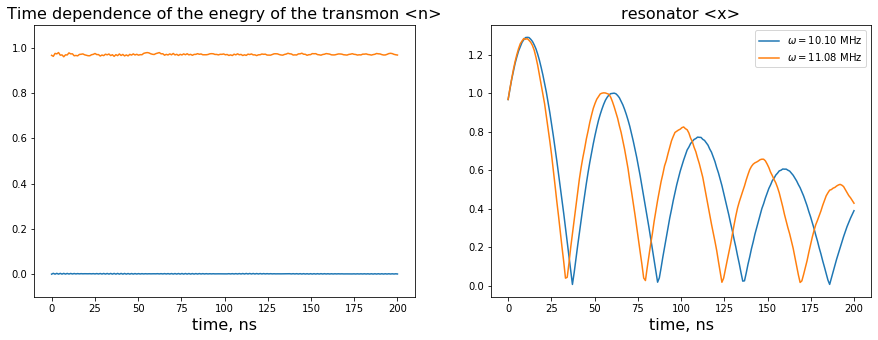

In [40]:
time = np.linspace(0, Time, Time // (clock*10) )
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(signal0['z0'])/nums)
f1.plot(time, np.abs(signal1['z0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>", size =16)
f1.set_xlabel('time, ns', size =16)
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(signal0['x2'])/nums, label='$\omega = 10.10$ MHz')
f2.plot(time, np.abs(signal1['x2'])/nums, label='$\omega = 11.08$ MHz')
f2.set_title("resonator <x>", size =16)
f2.set_xlabel('time, ns', size =16)
f2.legend()
plt.show()

[0.00514183 1.37315686 3.91787015 0.01010379]


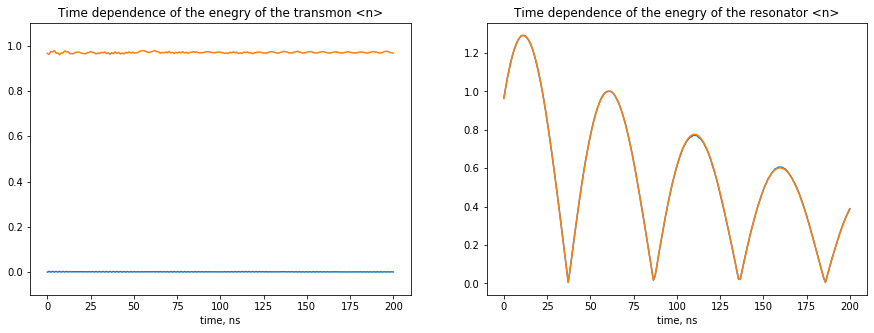

In [41]:
def func_for_disp(t, gamma, a, phi, f):
    return(np.abs(a * np.sin(2*np.pi*f*t + phi) * np.exp(- gamma * t)))
popt, pcov = curve_fit(func_for_disp, time, np.abs(signal0['x2'])/nums,\
                      bounds = ([0.009/2, 1, 0, 1/130], [0.011/2, 2, 2*np.pi, 1/70]))
print(popt)
time = np.linspace(0, Time, Time // (clock*10) )
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(signal0['z0'])/nums)
f1.plot(time, np.abs(signal1['z0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>")
f1.set_xlabel('time, ns')
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(signal0['x2'])/nums)
f2.plot(time, func_for_disp(time, *popt))
f2.set_title("Time dependence of the enegry of the resonator <n>")
f2.set_xlabel('time, ns')
plt.show()

[0.00497669 1.3523769  3.93530538 0.01106611]


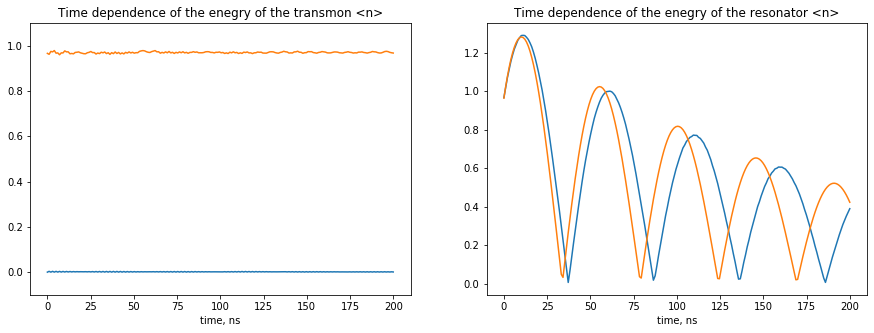

In [42]:
def func_for_disp(t, gamma, a, phi, f):
    return(np.abs(a * np.sin(2*np.pi*f*t + phi) * np.exp(- gamma * t)))
popt, pcov = curve_fit(func_for_disp, time, np.abs(signal1['x2'])/nums,\
                      bounds = ([0.009/2, 1, 0, 1/130], [0.011/2, 2, 2*np.pi, 1/70]))
print(popt)
time = np.linspace(0, Time, Time // (clock*10) )
fig, (f1, f2) = plt.subplots(
    nrows = 1, ncols = 2,
    figsize=(15, 5)
)
f1.plot(time, np.abs(signal0['z0'])/nums)
f1.plot(time, np.abs(signal1['z0'])/nums)
f1.set_title("Time dependence of the enegry of the transmon <n>")
f1.set_xlabel('time, ns')
f1.set_ylim(-0.1, 1.1)
#f2.plot(time, np.abs(x2mean))
f2.plot(time, np.abs(signal0['x2'])/nums)
f2.plot(time, func_for_disp(time, *popt))
f2.set_title("Time dependence of the enegry of the resonator <n>")
f2.set_xlabel('time, ns')
plt.show()